In [308]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from sympy import *
init_printing()
from IPython.display import display, Math
%matplotlib notebook

## The data

<IPython.core.display.Javascript object>


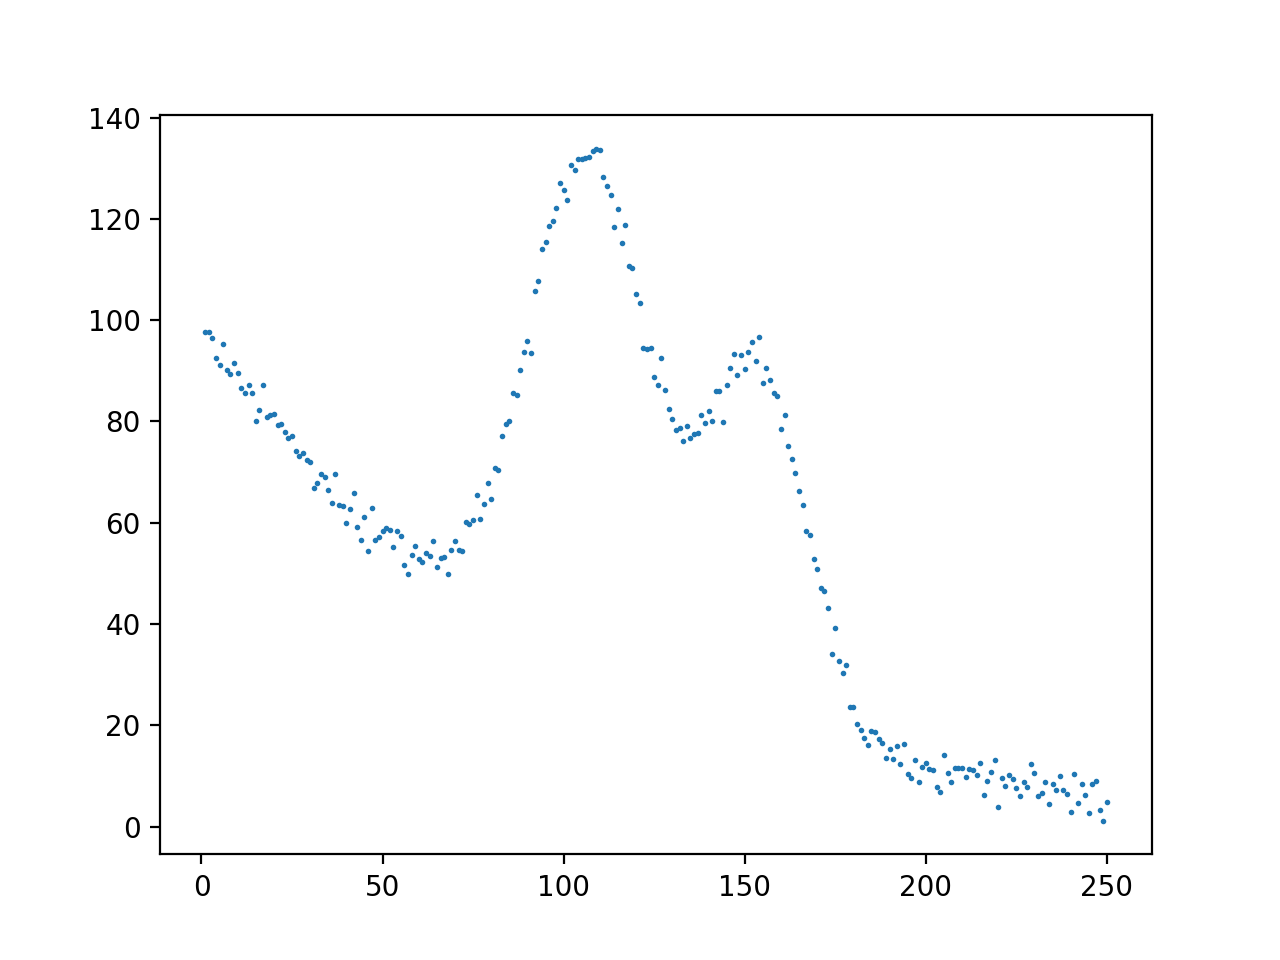

In [127]:
data = pd.read_clipboard(names=["x", "y"], index_col=0)

plt.scatter(data.index, data.y, s=1);

## The model:
$$
    \beta_1 \exp(\beta_2x) + \beta_3 exp\left(\frac{-(x - \beta_4)^2}{{\beta_5^2}}\right) + \beta_6 exp\left(\frac{-(x - \beta_7)^2}{{\beta_8^2}}\right)
$$

In [361]:
b1, b2, b3, b4, b5, b6, b7, b8, x, y = symbols("beta1 beta2 beta3 beta4 beta5 beta6 beta7 beta8 x y")

f = lambda x, b1, b2, b3, b4, b5, b6, b7, b8: b1 * exp(b2*x) + \
                                                 b3 * exp(-(x - b4)**2 / b5 **2) + \
                                                 b6 * exp(-(x - b7)**2 / b8 **2)

gi = lambda x, y, inputs: f(x, *inputs) - y

fs = Function("f")
gis = Function("g_i")
beta_hat = Symbol("betabar")
xi, yi = symbols("x_i, y_i")

inputs = xi, b1, b2, b3, b4, b5, b6, b7, b8
betas = b1, b2, b3, b4, b5, b6, b7, b8
variables = b1, b2, b3, b4, b5, b6, b7, b8, xi, yi

In [ ]:
pae

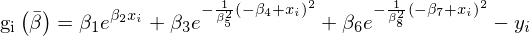

In [344]:
Eq(gis(beta_hat), gi(yi, xi, betas))

## The derivatives

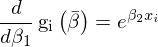

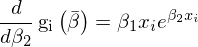

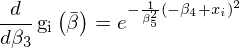

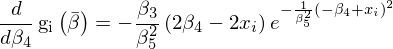

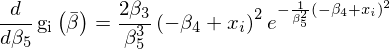

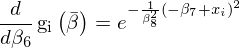

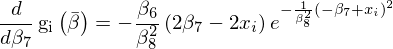

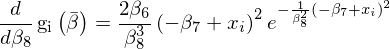

In [292]:
# Creating a list of gradients for every gi
gradient_i = []
for beta in betas:
    partial_eq = diff(gi(yi, xi, betas), beta)
    partial_func = Derivative(gis(beta_hat), beta)
    gradient_i.append(partial_eq)
    display(Eq(partial_func, partial_eq))

In [406]:
def jacobian_errors(data, beta_k, varbs, gradient_func):
    """
    Return the Jacobian and G_errors to compute
    one iteration of the Gauss-Newton method.
    :param data: The input data in which'y' is the column name to predict
    :param beta_k: a list of beta elements to pass in the model (the variables to find)
    :param varbs: list of defined sympy variables
    :param gradient_func: a list of sympy derivives of the error function to minimize
    """
    jacobian = []
    g_err = []
    for xp, yp in zip(data.index, data.y):
        # Filling Jacobian Matrix
        parmeters = []
        parmeters.extend(beta_k)
        parmeters.extend([xp, yp])
        efunc = {var: value for (var, value) in
                            zip(varbs, parmeters)}
        gradient_i_val = [grad.subs(efunc) for grad in gradient_func]
        jacobian.append(gradient_i_val)

        # Filling G_error function matrix
        g_err.append(gi(xp, yp, beta_k))


    jacobian = np.array(jacobian).astype(float)
    g_err = np.array([g_err]).astype(float).T
    
    return jacobian, g_err

In [444]:
# Starting Beta
beta_k = [96, 0.009, 103, 106, 18, 72, 151, 18]
# List of fitted curves
Y = []
for i in range(10):
    print(i)
    Y_i = [f(x, *beta_k) for x in X]
    Y.append(np.array(Y_i).astype(float))
    jacb, gerr = jacobian_errors(data, beta_k, variables, gradient_i)
    beta_k = (np.array([beta_k]).T - inv(jacb.T @ jacb) @ (jacb.T @ gerr)).ravel()

0
1
2
3
4
5
6
7
8
9


In [446]:
d = pd.DataFrame(Y).T
d.index = np.linspace(0, 250, 1000)
d.columns = {"It_{}".format(i) for i in range(10)}

<IPython.core.display.Javascript object>


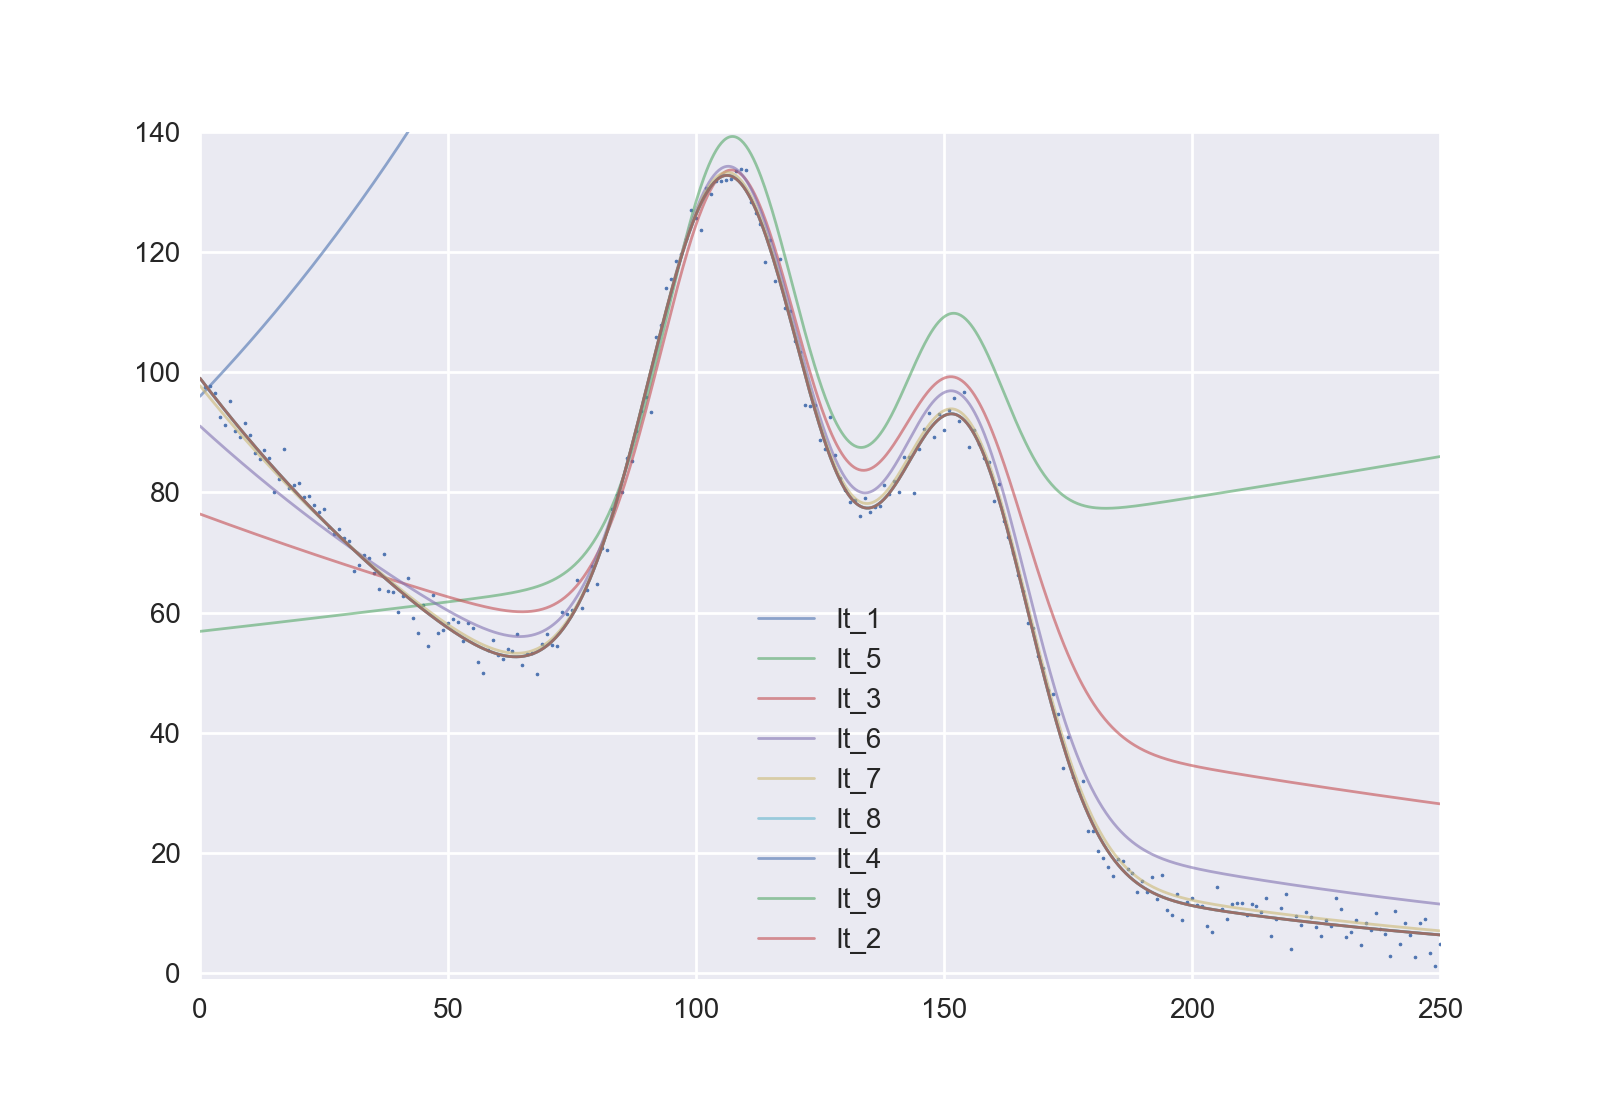

In [447]:
ax = d.drop("It_0", 1).plot(alpha=0.6, linewidth=1)
plt.scatter(data.index, data.y, s=1)
plt.xlim(0, 250)
plt.ylim(-1, 140)

In [448]:
sum(g_err**2) - 1.2475282092E+03

array([  1.75684909e-06])